In [1]:
import numpy as np
from glob import glob
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib notebook

# Parameter Setup

In [3]:
folder = 'data/180513_1_Load_Curve'

# Readin power/temperature data

In [4]:
power_table = Table.read('%s/power_log.txt'%folder, format='ascii', data_start=2)
temp_table = Table.read('%s/temp_log.txt'%folder, format='ascii', data_start=2)
print power_table[:5]
print temp_table[:5]

    ctime      Voltage1 Current1 Power_40K  Voltage2 Current2 Power_4K
-------------- -------- -------- --------- --------- -------- --------
1526219458.989  0.08718 0.040493   0.00353 -0.000423  3.7e-05     -0.0
1526219459.225  0.08718 0.040493   0.00353 -0.001327  3.7e-05     -0.0
 1526219459.46  0.08718 0.040493   0.00353 -0.000573  3.5e-05     -0.0
1526219459.696  0.08719 0.040493  0.003531 -0.001176  3.5e-05     -0.0
1526219459.942  0.08717 0.040498   0.00353 -0.001327  3.7e-05     -0.0
    ctime      40K_cold_plate 4K_cold_plate
-------------- -------------- -------------
1526219446.396         27.073         2.638
1526219446.496         27.148         2.606
1526219446.599         27.054         2.612
1526219446.699         26.834          2.63
1526219446.799         26.643         2.685


# Find out the power step positions

In [9]:
ctime = power_table['ctime']
idx = np.where(np.diff(ctime) > 1.2)[0] + 1
sep_times = ctime[idx]
for sec_num, i in enumerate(idx):
    print sec_num, int(ctime[i]), 
    if sec_num == 0 :
        print int(ctime[i] - ctime[0]),
    else:
        print int(ctime[i] - ctime[idx[sec_num - 1]]),
    print '40K Power:', power_table['Power_40K'][i], 'W',
    print '4K Power:', power_table['Power_4K'][i], 'W'
ctime_flags = ctime[idx]

0 1526223058 3599 40K Power: 0.003514 W 4K Power: 0.487581 W
1 1526226658 3600 40K Power: 0.003515 W 4K Power: 0.993127 W
2 1526230258 3600 40K Power: 0.00353 W 4K Power: 1.502076 W
3 1526233859 3600 40K Power: 0.00354 W 4K Power: -0.0 W
4 1526237459 3600 40K Power: 0.003547 W 4K Power: 0.0 W
5 1526241059 3600 40K Power: 3.799693 W 4K Power: 0.0 W
6 1526244659 3599 40K Power: 3.739913 W 4K Power: 0.487672 W
7 1526248259 3600 40K Power: 3.738917 W 4K Power: 0.992954 W
8 1526251859 3600 40K Power: 3.740245 W 4K Power: 1.501825 W
9 1526255460 3600 40K Power: 0.003589 W 4K Power: 0.0 W
10 1526259060 3599 40K Power: 0.003485 W 4K Power: -0.0 W
11 1526262660 3600 40K Power: 7.60919 W 4K Power: 0.0 W
12 1526266260 3599 40K Power: 7.500528 W 4K Power: 0.488023 W
13 1526269860 3600 40K Power: 7.501469 W 4K Power: 0.993689 W
14 1526273460 3600 40K Power: 7.499587 W 4K Power: 1.502043 W
15 1526277060 3600 40K Power: 0.003628 W 4K Power: 0.0 W


## Plotting overall data

<IPython.core.display.Javascript object>


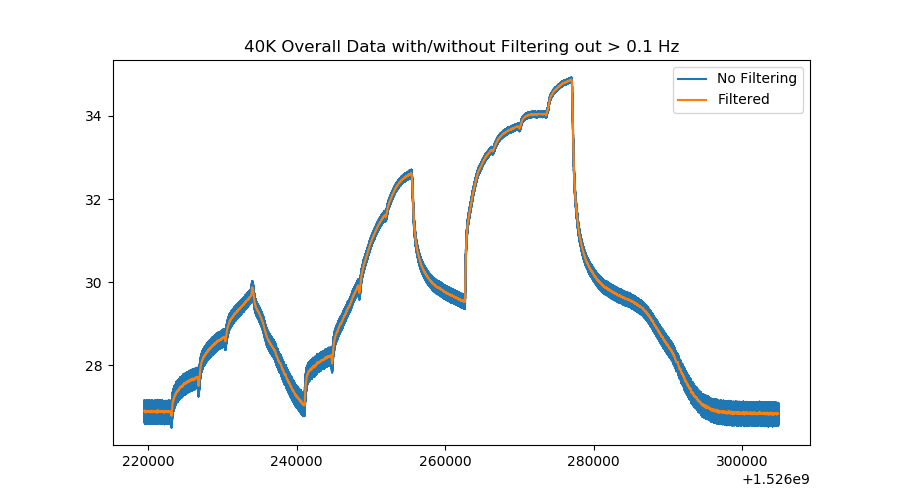

In [129]:
x_overall = temp_table['ctime']
y_overall = temp_table['40K_cold_plate']
x_filtered, y_filtered = filtering(x_overall), filtering(y_overall)
fig1, ax1 = plt.subplots(figsize=(9, 5))
plt.title('40K Overall Data with/without Filtering out > 0.1 Hz')
ax1.plot(x_overall, y_overall, label='No Filtering')
ax1.plot(x_filtered, y_filtered, label='Filtered')
ax1.legend()

In [5]:
def filtering(data, avg_factor=100):
    '''Filtering data with avg_factor by averaging'''
    n_sample = (len(data)//avg_factor) * avg_factor
    data_reshape = data[:n_sample].reshape((-1, avg_factor))
    data_filtered = np.average(data_reshape, axis=1)
    return data_filtered

## Fit & Plot section-by-section

In [6]:
def fit_ultimate_temp(ax, time, temp, text_lower):
    '''Fit the ultimate temperature given
    the measured temp with corresponding time
    and plot the results on 'ax'
    text_lower: vertical text offset
    '''
    def exp(x, y0, x0, dy, lamda):
        '''y = y0 - d_y*exp(-(x - x0)/lamda)
        '''
        return y0 - dy*np.exp(-(x - x0)/lamda)
    try:
        p, cov = curve_fit(exp, time, temp, p0=[25, time[0], 0, 1000])
        print 'Ultimate Temp:', p[0]
    except:
        print 'Fitting failed!'
        ax.text(np.mean(time) + 1000, np.mean(temp) - text_lower, '###',
                va='center', ha='center',)
        return
    ax.plot(time, exp(time, *p))
    ax.text(np.mean(time) + 1000, np.mean(temp) - text_lower, '%.1fK'%p[0],
            va='center', ha='center',)

In [7]:
def data_sel(ax, i, front_skip=30, end_skip=20, text_lower=0.4):
    '''Plot the sections of the fit
    from the given index i
    '''
    if i == 0:
        idx = np.where(x_filtered < sep_times[i])[0]
    else:
        idx = np.where((x_filtered > sep_times[i-1]) &\
                   (x_filtered < sep_times[i]))[0]
    x_t = x_filtered[idx]
    y_t = y_filtered[idx]
    fit_ultimate_temp(ax, x_t[front_skip:-end_skip], y_t[front_skip:-end_skip],
                      text_lower=text_lower,)

NameError: name 'x_filtered' is not defined

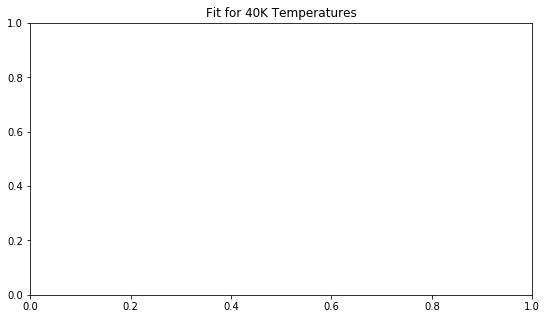

In [8]:
fig2, ax2 = plt.subplots(figsize=(9, 5))
plt.title('Fit for 40K Temperatures')
ax2.plot(x_filtered[x_filtered < sep_times[-1]], 
         y_filtered[x_filtered < sep_times[-1]], label='Measurements')

idx_list = range(16)
for i in idx_list:
    data_sel(ax2, i)

# 40K Stage

Ultimate Temp: 25.186720486069046
Ultimate Temp: 27.75210368821473
Ultimate Temp: 28.731715625094232
Ultimate Temp: 29.939665751365794
Ultimate Temp: 26.34033432100691
Ultimate Temp: 26.25423411323901
Ultimate Temp: 28.42561185195413
Ultimate Temp: 35.1409388909804
Ultimate Temp: 32.2003036262585
Ultimate Temp: 32.732378646813466
Ultimate Temp: 29.864725858529916
Ultimate Temp: 29.026184858252925
Ultimate Temp: 33.38936982882015
Ultimate Temp: 33.76691756313297
Ultimate Temp: 34.039164312464045
Ultimate Temp: 34.85125038231865


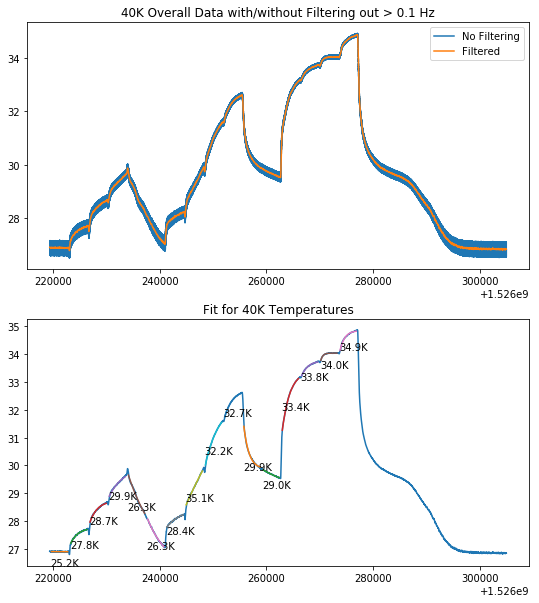

In [10]:
x_overall = temp_table['ctime']
y_overall = temp_table['40K_cold_plate']
x_filtered, y_filtered = filtering(x_overall), filtering(y_overall)
fig4, ax4 = plt.subplots(nrows=2, figsize=(9, 10))
ax4[0].set_title('40K Overall Data with/without Filtering out > 0.1 Hz')
ax4[0].plot(x_overall, y_overall, label='No Filtering')
ax4[0].plot(x_filtered, y_filtered, label='Filtered')
ax4[0].legend()

ax4[1].set_title('Fit for 40K Temperatures')
ax4[1].plot(x_filtered, 
            y_filtered, label='Measurements')

idx_list = range(16)
for i in idx_list:
    data_sel(ax4[1], i, end_skip=25, text_lower=0.4)

# 4K Stage

Ultimate Temp: 2.2660962385190357
Ultimate Temp: 4.041711665106353
Ultimate Temp: 4.9620509560552515
Ultimate Temp: 5.582436278818766
Ultimate Temp: 2.875640151650499
Ultimate Temp: 2.6811823331495916
Ultimate Temp: 3.073838727010672
Ultimate Temp: 4.322796615269344
Fitting failed!
Ultimate Temp: 6.318016720379063
Ultimate Temp: 3.217388225619542
Ultimate Temp: 2.4282262623746504
Ultimate Temp: 3.7857138012905334
Ultimate Temp: 4.805052940128319
Ultimate Temp: 5.679110190385324
Ultimate Temp: 6.615719467422648


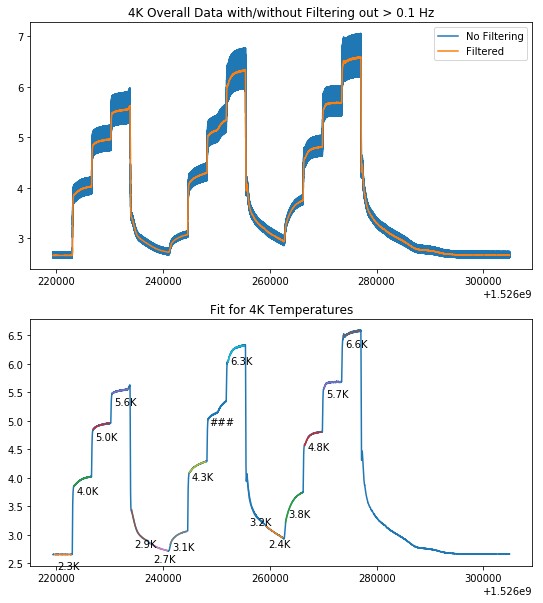

In [11]:
x_overall = temp_table['ctime']
y_overall = temp_table['4K_cold_plate']
x_filtered, y_filtered = filtering(x_overall), filtering(y_overall)
fig3, ax3 = plt.subplots(nrows=2, figsize=(9, 10))
ax3[0].set_title('4K Overall Data with/without Filtering out > 0.1 Hz')
ax3[0].plot(x_overall, y_overall, label='No Filtering')
ax3[0].plot(x_filtered, y_filtered, label='Filtered')
ax3[0].legend()

ax3[1].set_title('Fit for 4K Temperatures')
ax3[1].plot(x_filtered, 
            y_filtered, label='Measurements')

idx_list = range(16)
for i in idx_list:
    data_sel(ax3[1], i, end_skip=25, text_lower=0.2)

# Select the Section

In [9]:
i = 1
if (i != -1) and (i+1 < len(ctime_flags)) :
    idx2 = np.where((temp_table['ctime'] > ctime_flags[i]) &
                    (temp_table['ctime'] < ctime_flags[i+1]))[0]
else:
    idx2 = np.where((temp_table['ctime'] > ctime_flags[i]))[0]
print 'Number of data points: %d'%len(idx2)

Number of data points: 35672


In [10]:
x = temp_table['ctime'][idx2][cut:]
y = temp_table[ch][idx2][cut:]
print len(x)

35072


idx_t = range(len(x)) > np.argmax(y)
x = x[idx_t]
y = y[idx_t]

Ultimate Temp: 4.938504986789096


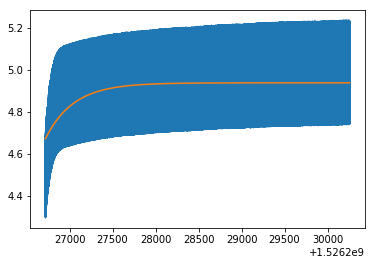

In [11]:
p, cov = curve_fit(exp, x, y, p0=[25, x[0], 0, 1000])
print 'Ultimate Temp:', p[0]
plt.plot(x, y)
plt.plot(x, exp(x, *p))